# Analysis of WaterLevels in Arnhem

Analysis of the waterlevels in Arnhem to determine number of moves of the pontoons of the local rowing-club.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from meteostat import Point, Daily

In [2]:
from common import RWSData, correlation_significance

# Getting data

## Water level data

We get data for the last three months, for this we use the previously defined class `RWSData`.
And select the measured value (in dutch).

In [3]:
dframes = []

loc1 = RWSData(('ARNHM', 700000.776754401, 5762308.24570394))
for n in range(1800, 2024):
    dframes.append(loc1.data_loc_datetime(datetime(n, 1, 1, 0), datetime(n+1, 1, 1, 0))[0][1])

loc2 = RWSData(('ARNH' , 700021.921999557, 5762290.37468757))
dframes.append(loc2.data_loc_datetime(datetime(2024, 1, 1, 0), datetime(2025, 1, 1, 0))[0][1])
wl_df = pd.concat(dframes)

In [4]:
raw_series = wl_df['Meetwaarde.Waarde_Numeriek']
raw_series.name = 'WaterLevel'
raw_series.reset_index().describe(datetime_is_numeric=True)

,Tijdstip,WaterLevel
count,750543,750543.000000
mean,2006-03-03 16:47:05.285693440,817.618925
min,1800-01-01 08:40:00,572.000000
25%,2014-02-04 19:25:00,756.000000
50%,2017-09-02 17:30:00,822.000000
75%,2021-03-28 17:25:00,842.000000
max,2024-11-02 20:30:00,1349.000000
std,NaN,97.369882


### Filtering

First we check how the the signal is distributed over time.
If the signal is equidistant in time then we can use filters such as moving average or FFT, otherwise not.
The signal is equidistant if all samples have the same time interval, this is not the case with our data.

In [5]:
np.diff(wl_df.index).astype(float).std()

48665709643435.125

### Groupby filtering

We attempt to use a groupby, this is supposedly a very robust way.
With this method we our data is still not equidistant, but this way we have the highest resolution (daily) over the longest period.
We are, however, unable to do any more filtering (groupby can be considered filtering).

In [6]:
grp_daily = raw_series.groupby([raw_series.index.year, raw_series.index.month, raw_series.index.day]).median()
grp_daily.index = map(lambda x: datetime(*x), grp_daily.index.values)
grp_hourly = raw_series.groupby([raw_series.index.year, raw_series.index.month, raw_series.index.day, raw_series.index.hour]).median()
grp_hourly.index = map(lambda x: datetime(*x), grp_hourly.index.values)

In [7]:
pd.Series({
    'Hourly': np.diff(grp_hourly.index).astype(float).std(),
    'Daily': np.diff(grp_daily.index).astype(float).std()
})

Hourly    7.798185e+13
Daily     1.258075e+14
dtype: float64

<Axes: xlabel='Tijdstip'>

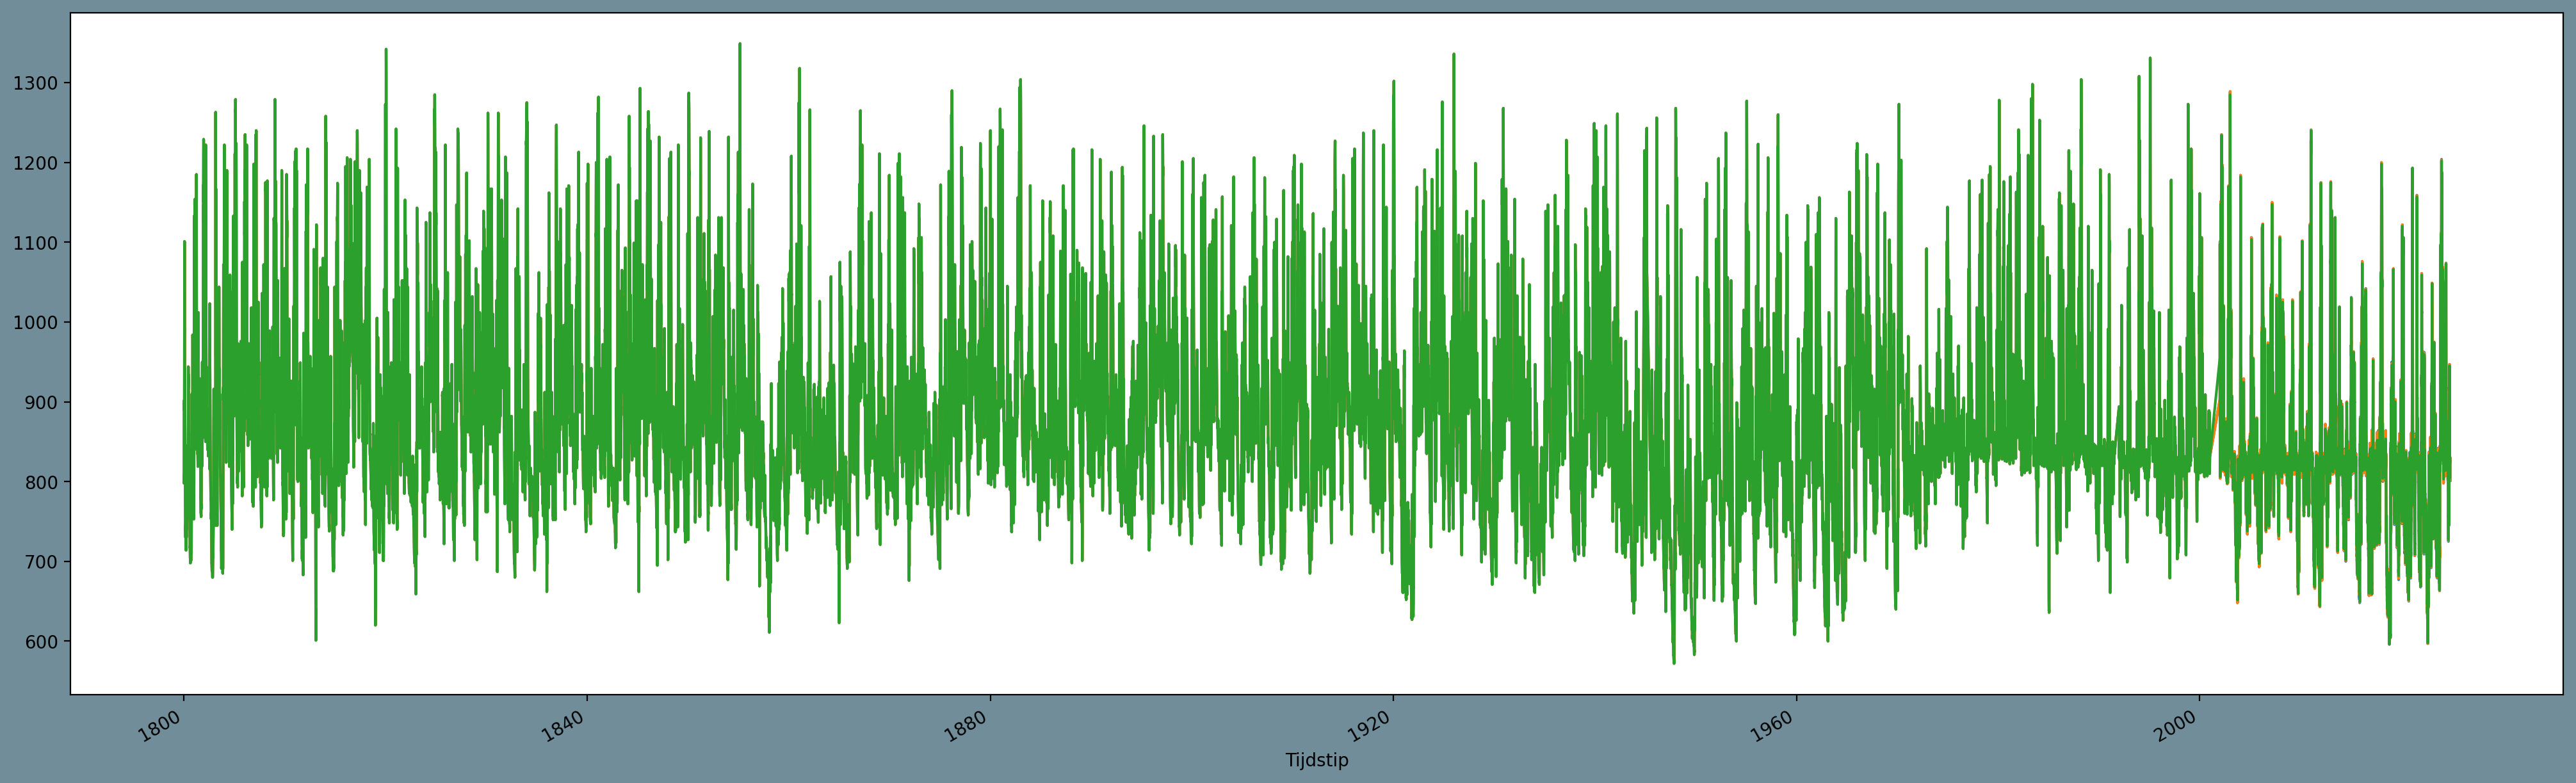

In [8]:
raw_series.plot()
grp_hourly.plot()
grp_daily.plot()

## Weather data

Next we get some weather data.
Not the complete period is available but one centrury will do for now.

In [9]:
rename = {'temp': 'Temperature', 'tavg': 'Temperature', 'prcp': 'Precipitation'}
select = ['Temperature', 'Precipitation']
loc_arnhem = Point(51.9800, 5.9111)

we_daily = Daily(
    loc_arnhem,
    # datetime.now()-timedelta(days=5),
    # datetime.now(),
    grp_daily.index.min().to_pydatetime(),
    grp_daily.index.max().to_pydatetime()
).fetch().rename(rename, axis=1)[select]
we_daily.reset_index().describe(datetime_is_numeric=True)

,time,Temperature,Precipitation
count,43863,39277.000000,38895.000000
mean,1964-10-17 00:00:00,9.758042,2.179182
min,1904-10-01 00:00:00,-15.400000,0.000000
25%,1934-10-09 12:00:00,5.000000,0.000000
50%,1964-10-17 00:00:00,9.900000,0.100000
75%,1994-10-25 12:00:00,14.900000,2.500000
max,2024-11-02 00:00:00,30.900000,81.900000
std,NaN,6.557002,4.374940


In [10]:
np.diff(we_daily.index).astype(float).std()

0.0

## Combined data

When we combine this data, we already see some slight trends.
For example, as the temperature rises the water levels tends to be lower.
Which is in line with common knowledge about waterlevels on the rhine.

A funny trend that is very clearly visible is the build of the weir and locks in Driel.

In [11]:
df = pd.concat([grp_daily, we_daily], axis=1)

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

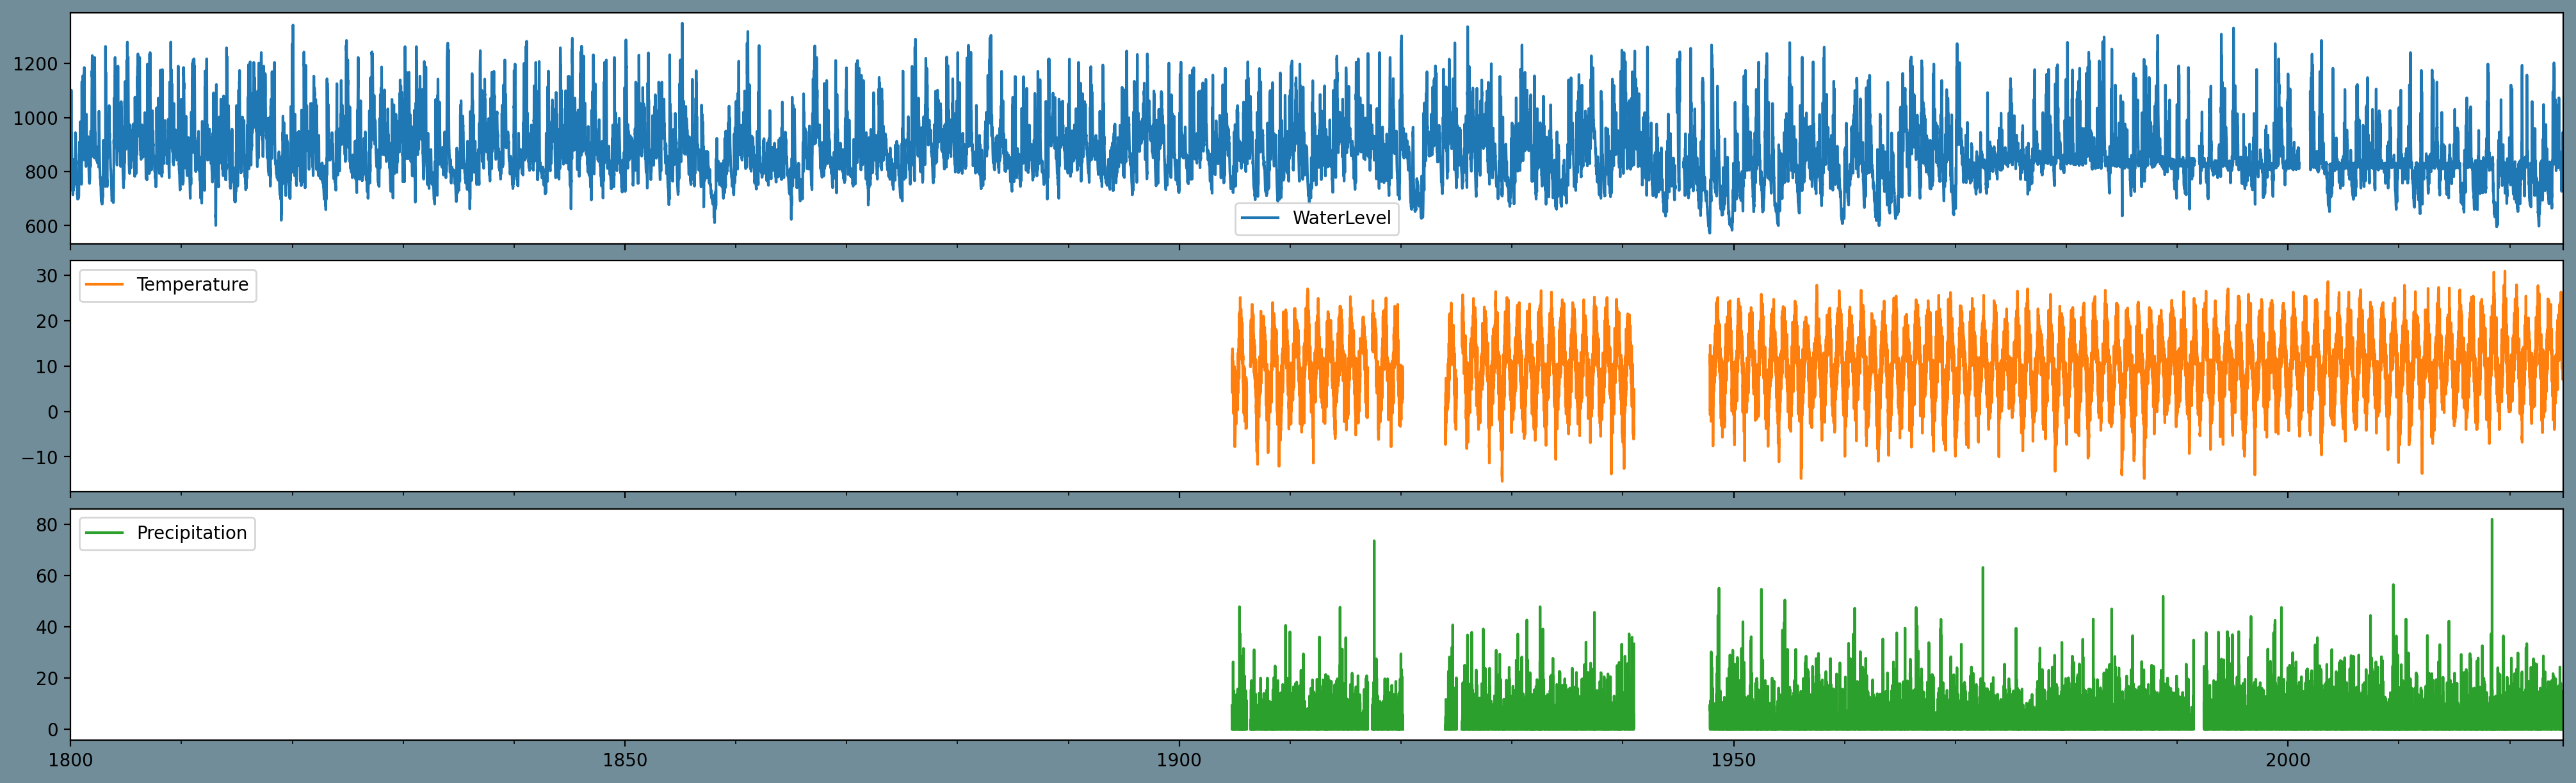

In [12]:
df.plot(subplots=True)

# Analysis

We also see that the waterlevels and temparature are relatively linear contrary to the precipation which is very non-linear.
When looking at the distribution we see several things.
Firstly, the waterlevel and precipitation is similary distributed if only look at the upper tail.
This might indicate a similarity in behavior.
Secondly, temperature seems to be fairly normally distributed.
The waterlevel is kept at a level of about 8 meter since 1970 resulting in a clearly defined peak around the mean.
If we ignore this peak the distribution looks somewhat normal.

In [13]:
ddf = df.describe()
ddf.loc['median'] = df.median()
ddf.loc['kurtosis'] = df.kurtosis()
ddf.loc['skewness'] = df.skew()
ddf

,WaterLevel,Temperature,Precipitation
count,81439.000000,39277.000000,38895.000000
mean,869.158094,9.758042,2.179182
std,110.164956,6.557002,4.374940
min,572.000000,-15.400000,0.000000
25%,802.000000,5.000000,0.000000
50%,849.000000,9.900000,0.100000
75%,924.000000,14.900000,2.500000
max,1349.000000,30.900000,81.900000
median,849.000000,9.900000,0.100000
kurtosis,1.036931,-0.457086,24.127394


array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>], dtype=object)

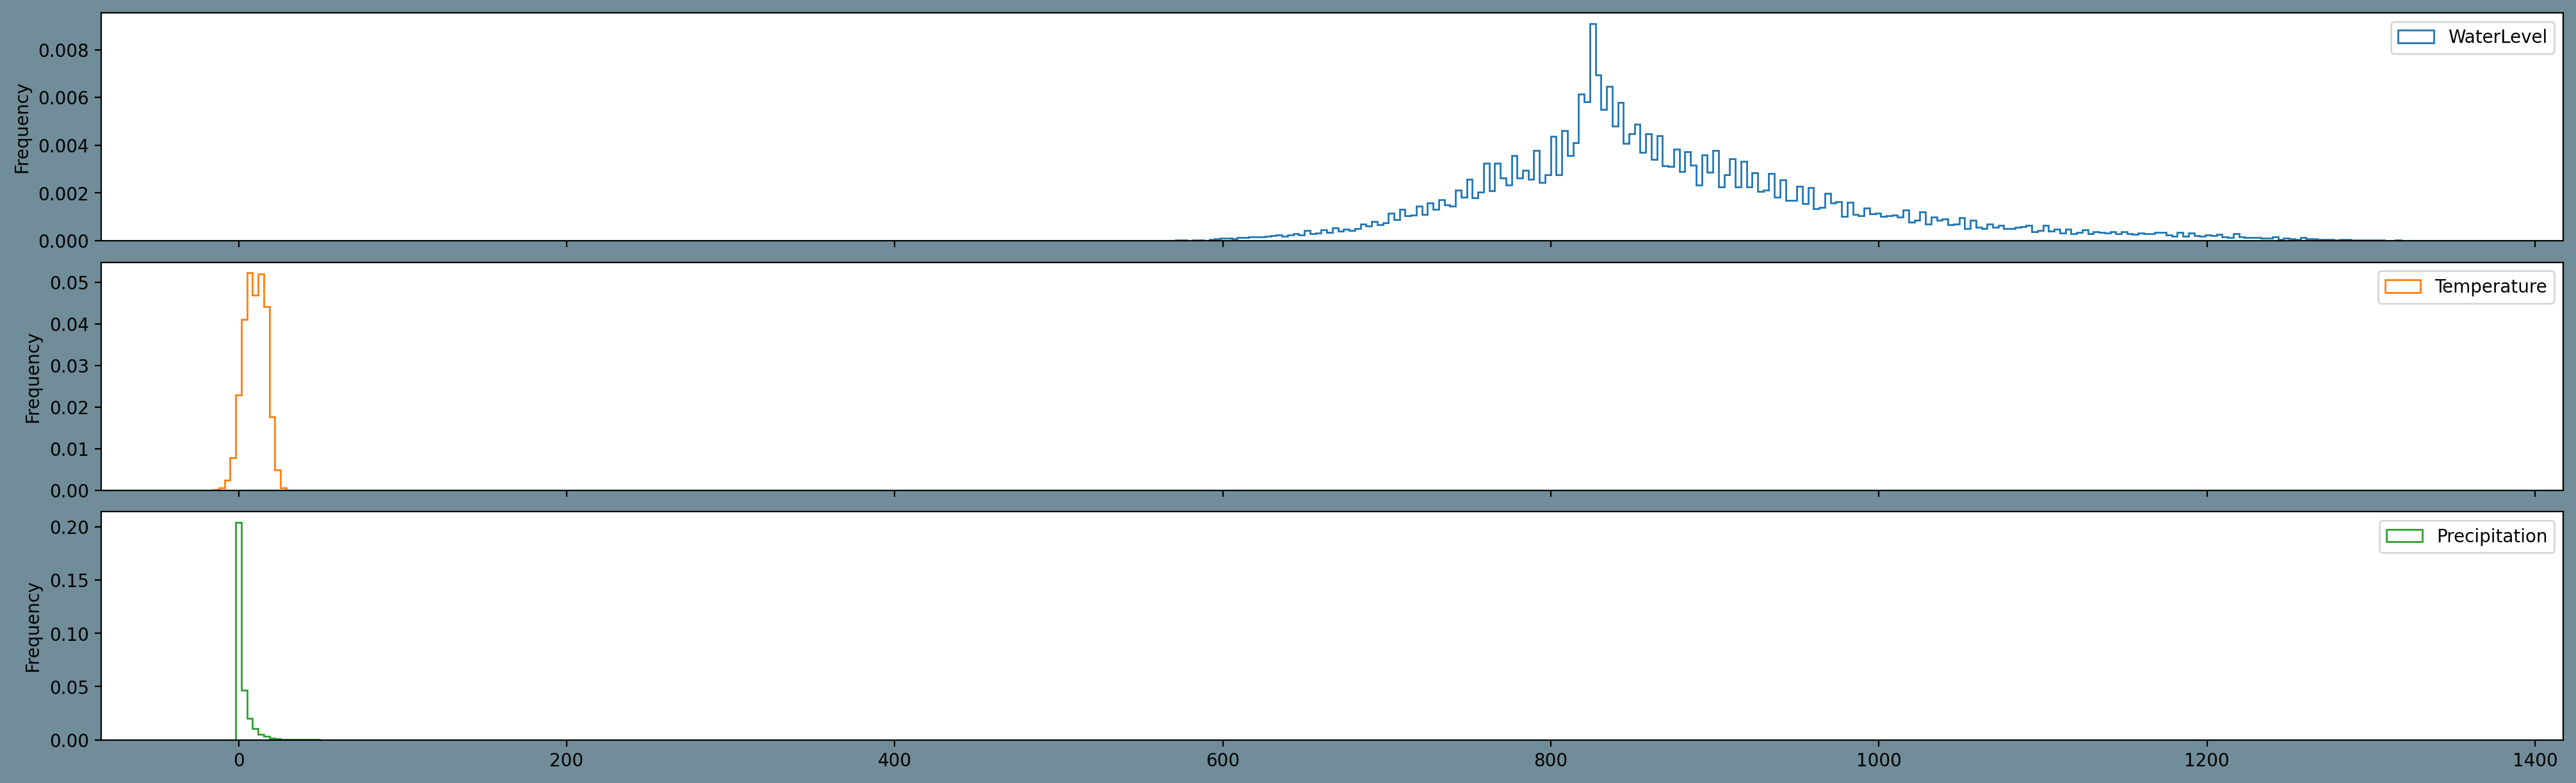

In [14]:
df.plot.hist(subplots=True, sharex=True, density=True, histtype='step', bins=400)

## Below threshold probability

One of the important bits in this analysis is determining the chance of extreme waterlevels.
We determine the change of low waterlevels below three separate levels.

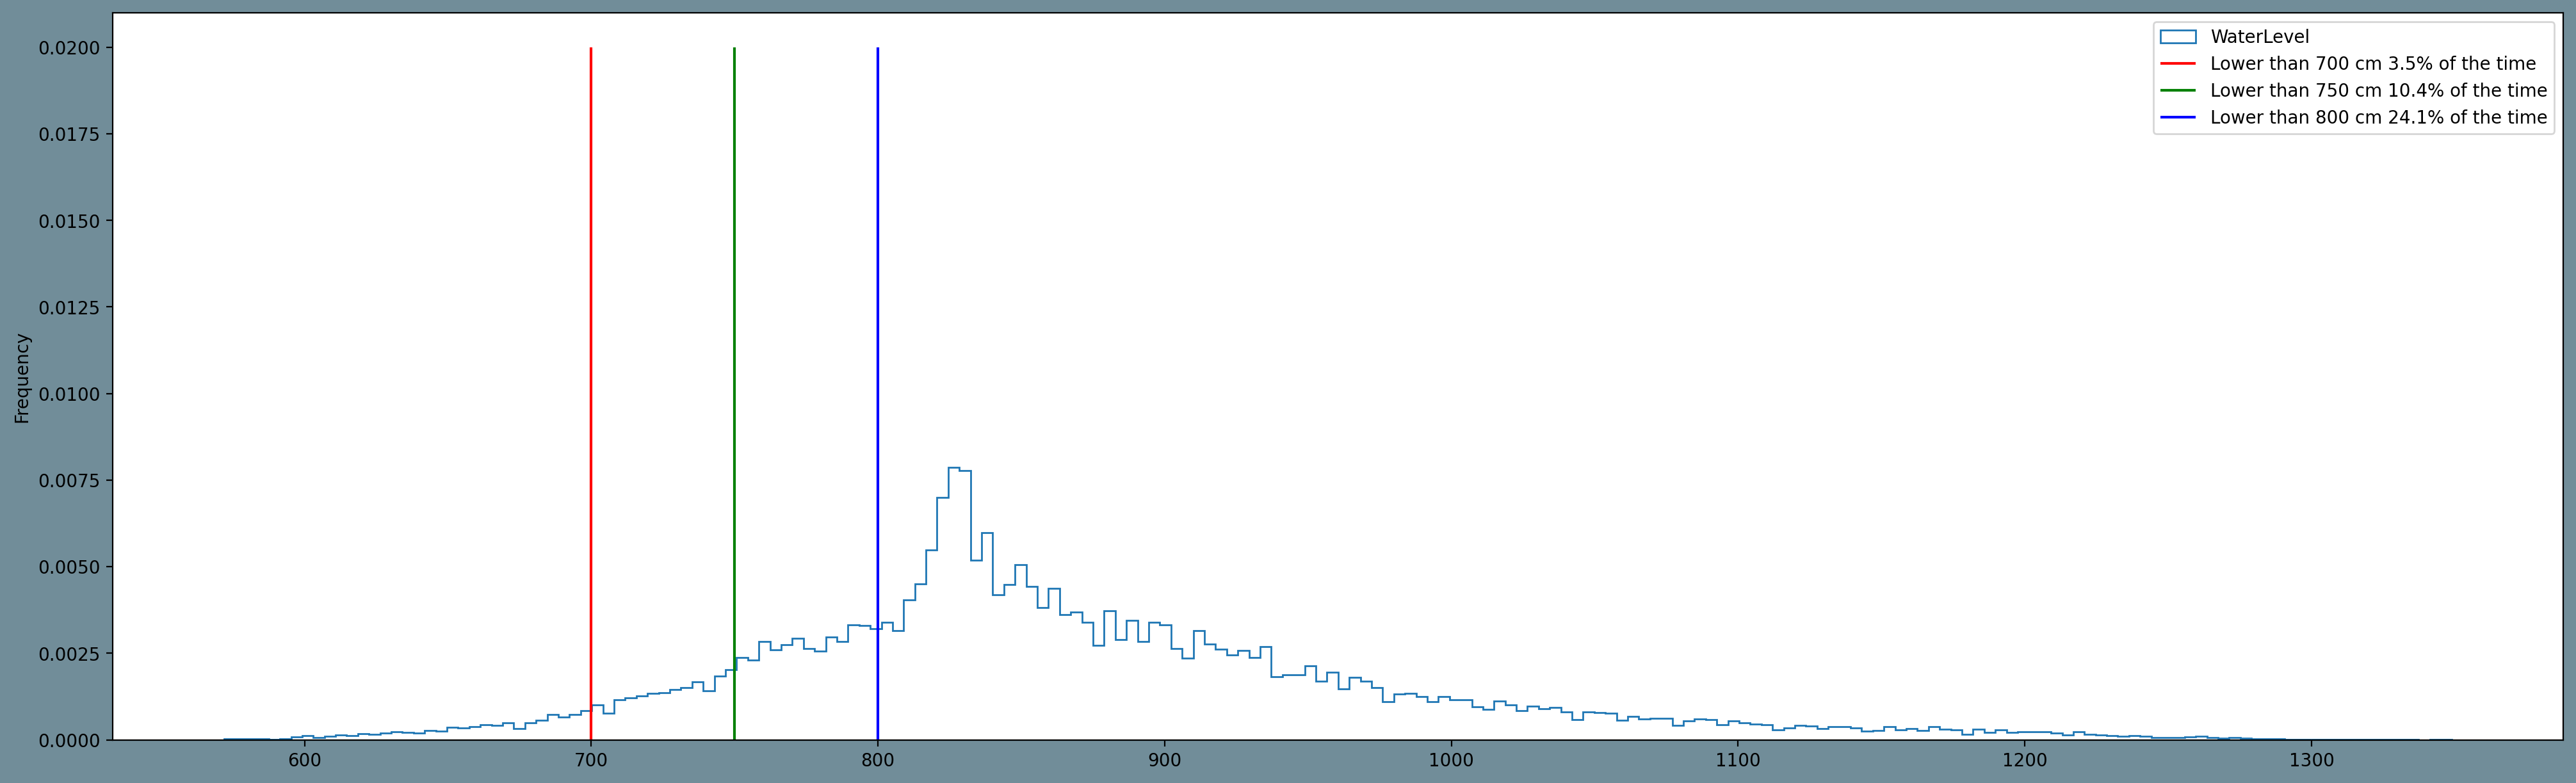

In [15]:
p700 = (grp_daily < 700).sum() / grp_daily.size
p750 = (grp_daily < 750).sum() / grp_daily.size
p800 = (grp_daily < 800).sum() / grp_daily.size

ax = grp_daily.plot.hist(bins=200, density=True, histtype='step')
ax.vlines(700, 0, 0.02, 'r', label=f'Lower than 700 cm {p700:.1%} of the time')
ax.vlines(750, 0, 0.02, 'g', label=f'Lower than 750 cm {p750:.1%} of the time')
ax.vlines(800, 0, 0.02, 'b', label=f'Lower than 800 cm {p800:.1%} of the time')
ax.legend()

## Correlation

We see that althought the correlation is very low for all features but that significance increases when we select earlier samples.
However, the largest significane is 0.668 between Temperature and Precipation and 0.006 for WaterLevel.
Suggesting that local rainfall or sunshine has no effect on local waterlevels.

What might be intresting to explore is how much rainfall further upstream might influence the waterlevels.

In [16]:
pd.concat({
    '1900<': correlation_significance(df.loc[1900<df.index.year].dropna()),
    '1910<': correlation_significance(df.loc[1910<df.index.year].dropna()),
    '1920<': correlation_significance(df.loc[1920<df.index.year].dropna()),
    '1930<': correlation_significance(df.loc[1930<df.index.year].dropna()),
    '1940<': correlation_significance(df.loc[1940<df.index.year].dropna()),
    '1950<': correlation_significance(df.loc[1950<df.index.year].dropna()),
    '1960<': correlation_significance(df.loc[1960<df.index.year].dropna()),
    '1970<': correlation_significance(df.loc[1970<df.index.year].dropna()),
    '1980<': correlation_significance(df.loc[1980<df.index.year].dropna()),
    '1990<': correlation_significance(df.loc[1990<df.index.year].dropna()),
    '2000<': correlation_significance(df.loc[2000<df.index.year].dropna()),
    '2010<': correlation_significance(df.loc[2010<df.index.year].dropna()),
    '2020<': correlation_significance(df.loc[2020<df.index.year].dropna()),
}).unstack(1).drop([('WaterLevel', 'Correlation', 'WaterLevel'), ('WaterLevel', 'P-Value', 'WaterLevel'),
                    ('Temperature', 'Correlation', 'Temperature'), ('Temperature', 'P-Value', 'Temperature'),
                    ('Precipitation', 'Correlation', 'Precipitation'), ('Precipitation', 'P-Value', 'Precipitation'),
                    ], axis=1)

WaterLevel                                         Temperature  \
      Correlation                   P-Value               Correlation   
      Temperature Precipitation Temperature Precipitation  WaterLevel   
1900<   -0.153899      0.030513         0.0           0.0   -0.153899   
1910<   -0.165101      0.031988         0.0           0.0   -0.165101   
1920<   -0.161494      0.031639         0.0           0.0   -0.161494   
1930<   -0.171491      0.033942         0.0           0.0   -0.171491   
1940<   -0.185674      0.036616         0.0           0.0   -0.185674   
1950<   -0.190049      0.033614         0.0           0.0   -0.190049   
1960<   -0.191135        0.0342         0.0           0.0   -0.191135   
1970<   -0.236311      0.026338         0.0      0.000288   -0.236311   
1980<   -0.248101      0.025193         0.0      0.001832   -0.248101   
1990<   -0.254787      0.039994         0.0      0.000016   -0.254787   
2000<   -0.266766       0.02995         0.0      0.006268   -0.266766   
2010<   -0.266915      0.055597         0.0      0.000078   -0.266915   
2020<   -0.329709      0.076477         0.0      0.004167   -0.329709   

                                             Precipitation              \
                       P-Value                 Correlation               
      Precipitation WaterLevel Precipitation    WaterLevel Temperature   
1900<       0.04501        0.0           0.0      0.030513     0.04501   
1910<      0.044975        0.0           0.0      0.031988    0.044975   
1920<      0.048935        0.0           0.0      0.031639    0.048935   
1930<      0.048073        0.0           0.0      0.033942    0.048073   
1940<      0.049341        0.0           0.0      0.036616    0.049341   
1950<      0.049987        0.0           0.0      0.033614    0.049987   
1960<      0.047458        0.0           0.0        0.0342    0.047458   
1970<      0.044609        0.0           0.0      0.026338    0.044609   
1980<      0.046206        0.0           0.0      0.025193    0.046206   
1990<      0.051639        0.0           0.0      0.039994    0.051639   
2000<      0.041018        0.0      0.000181       0.02995    0.041018   
2010<      0.026706        0.0      0.057962      0.055597    0.026706   
2020<      0.011457        0.0      0.668194      0.076477    0.011457   

                              
         P-Value              
      WaterLevel Temperature  
1900<        0.0         0.0  
1910<        0.0         0.0  
1920<        0.0         0.0  
1930<        0.0         0.0  
1940<        0.0         0.0  
1950<        0.0         0.0  
1960<        0.0         0.0  
1970<   0.000288         0.0  
1980<   0.001832         0.0  
1990<   0.000016         0.0  
2000<   0.006268    0.000181  
2010<   0.000078    0.057962  
2020<   0.004167    0.668194

## Most probable maximum

If we take a look at estimating the the most probable extreme values we see that it is seems that weibull estimates the MPM quite well.
We check this by evaluating the fit to earlier determined probabilities of certian extreme waterlevels.

We can then use that fit to estimate the waterlevel for any return period.
The 200 year return value should be somewhere near 1349 cm, since that is highest waterlevel on record.
The fit slightly overestimates this, but the error is acceptable.

In [17]:
from scipy.stats import weibull_min

wfit = weibull_min.fit(grp_daily.dropna())
pd.Series(
    weibull_min.cdf([700, 750, 800], *wfit),
    [700, 750, 800]
)

700    0.065050
750    0.156787
800    0.290316
dtype: float64

In [18]:
pd.DataFrame({
    '200 year return':  [weibull_min.isf(1/(200*365.25), *wfit), weibull_min.isf(1 - 1/(200*365.25), *wfit)],
    '100 year return':  [weibull_min.isf(1/(100*365.25), *wfit), weibull_min.isf(1 - 1/(100*365.25), *wfit)],
    '10 year return':   [weibull_min.isf(1/(10*365.25), *wfit),  weibull_min.isf(1 - 1/(10*365.25), *wfit)],
    '1 year return':    [weibull_min.isf(1/(1*365.25), *wfit),   weibull_min.isf(1 - 1/(1*365.25), *wfit)],
    '1/2 year return':  [weibull_min.isf(2/(1*365.25), *wfit),   weibull_min.isf(1 - 2/(1*365.25), *wfit)],
    '1 month return':   [weibull_min.isf(12/(1*365.25), *wfit),  weibull_min.isf(1 - 12/(1*365.25), *wfit)],
    '1 week return':    [weibull_min.isf(1/7, *wfit),            weibull_min.isf(6/7, *wfit)],
    '1 day return':     [weibull_min.isf(1/2, *wfit),            weibull_min.isf(1/2, *wfit)],
}, index=['High waterlevels', 'Low waterlevels']).T

,High waterlevels,Low waterlevels
200 year return,1355.944569,578.195186
100 year return,1338.401692,579.951835
10 year return,1274.096791,590.123042
1 year return,1196.757988,613.130121
1/2 year return,1169.705535,624.632861
1 month return,1086.765379,671.873418
1 week return,993.741260,743.740228
1 day return,864.564578,864.564578


# References:

1. https://rijkswaterstaat.github.io/wm-ws-dl/#introduction
1. https://meteostat.net/en/station/06275?t=2000-01-01/2000-01-31
1. https://www.gelderlander.nl/arnhem/hoogwaterpiek-13-meter~ac9b2371/#:~:text=Het%20is%20voor%20het%20eerst,boven%20NAP%20de%20hoogste%20waterstand.
1. https://www.rijkswaterstaat.nl/water/waterbeheer/bescherming-tegen-het-water/waterkeringen/dammen-sluizen-en-stuwen/stuwensemble-nederrijn-en-lek